<a href="https://colab.research.google.com/github/TapasKumarDutta1/IEEE-CIS-Fraud/blob/master/autoenc_prep_with_id.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, concatenate
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from keras.utils import Sequence, get_custom_objects
from keras import backend as K
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from google.colab import drive
from tqdm import tqdm
import random
from math import ceil, floor
import gc

Loading the drive

In [ ]:

drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Mounted at /content/gdrive


Importing libraries

In [ ]:
np.random.seed(42) # NumPy
random.seed(42) # Python

Loading data

In [ ]:
# Read the training and test data from CSV files and set the first column as the index
trn = pd.read_csv("/content/gdrive/My Drive/fraud/train_id.csv", index_col=[0])
tst = pd.read_csv("/content/gdrive/My Drive/fraud/test_id.csv", index_col=[0])

# Define the list of categorical columns as strings from 0 to 443
categorical = [str(i) for i in range(444)]

# Convert the categorical columns in the training DataFrame to uint8 data type
trn[categorical] = trn[categorical].astype("uint8")

# Convert the categorical columns in the test DataFrame to uint8 data type
tst[categorical] = tst[categorical].astype("uint8")


Drop  isFraud

In [ ]:
trn = trn.drop(["isFraud"], 1)
trn.shape, tst.shape

((590540, 617), (506691, 617))

Reduce memory useage

In [ ]:
def reduce_mem_usage(df):
    """
    Reduce the memory usage of a DataFrame by downcasting the numeric columns to smaller data types.

    Parameters:
        df (DataFrame): The DataFrame to be optimized.

    Returns:
        DataFrame: The DataFrame with reduced memory usage.

    Example:
        trn = reduce_mem_usage(trn)
        tst = reduce_mem_usage(tst)
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

# Reduce memory usage for training and test DataFrames
trn = reduce_mem_usage(trn)
tst = reduce_mem_usage(tst)

Memory usage of dataframe is 1034.00 MB
Memory usage after optimization is: 663.43 MB
Decreased by 35.8%
Memory usage of dataframe is 887.19 MB
Memory usage after optimization is: 566.33 MB
Decreased by 36.2%


Concatenate data

In [ ]:
# Concatenate trn and tst DataFrames and reset index
X = pd.concat([trn, tst]).reset_index(drop=True)

# Delete trn and tst DataFrames to free up memory
del trn, tst

# Convert categorical columns to uint8 data type to optimize memory usage
categorical = [str(i) for i in range(444)]
X[categorical] = X[categorical].astype("uint8")

# Perform garbage collection to release unused memory
gc.collect()

0

Divide data into categorical and numerical

In [ ]:

# Define the categorical columns as a list of strings from 0 to 443
cat = [str(i) for i in range(444)]

# Convert the categorical columns to uint8 data type to optimize memory usage
X[cat] = X[cat].astype('uint8')

# Find columns that are not categorical (numerical columns)
no_dum = [i for i in X.columns if i not in cat]

# Get the number of numerical and categorical features
num_shape = len(no_dum)
cat_shape = len(cat)

# Perform garbage collection to release unused memory
gc.collect()

def custom_gelu(x):
    """
    Custom Gaussian Error Linear Unit (GELU) activation function.

    Parameters:
        x (Tensor): The input tensor.

    Returns:
        Tensor: The output tensor after applying the custom GELU activation.

    Example:
        x = custom_gelu(x)
    """
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))
def create_model():
    """
    Create a custom neural network model.

    Returns:
        Model: The compiled neural network model.

    Example:
        model = create_model()
    """
    K.clear_session()
    num_inp = Input(shape=(num_shape,))
    cat_inp = Input(shape=(cat_shape,))
    inps = concatenate([num_inp, cat_inp])
    x = Dense(512, activation=custom_gelu)(inps)
    x = Dense(256, activation=custom_gelu)(x)
    x = Dense(512, activation=custom_gelu)(x)
    x = Dropout(0.2)(x)
    cat_out = Dense(cat_shape, activation="linear")(x)
    num_out = Dense(num_shape, activation="linear")(x)
    model = Model(inputs=[num_inp, cat_inp], outputs=[num_out, cat_out])
    model.compile(optimizer=Adam(0.05, clipnorm=1, clipvalue=1), loss=["mse", "mse"])
    return model

Warmup learning rate

In [ ]:

class WarmUpLearningRateScheduler(keras.callbacks.Callback):
    """
    Custom Callback to implement a warm-up learning rate scheduler.

    Parameters:
        warmup_batches (int): The number of batches for the warm-up phase.
        init_lr (float): The initial learning rate before warm-up.
        verbose (int): Whether to print messages about learning rate changes.

    Example:
        warmup_lr_scheduler = WarmUpLearningRateScheduler(warmup_batches=100, init_lr=0.01, verbose=1)
    """

    def __init__(self, warmup_batches, init_lr, verbose=0):
        super(WarmUpLearningRateScheduler, self).__init__()
        self.warmup_batches = warmup_batches
        self.init_lr = init_lr
        self.verbose = verbose
        self.batch_count = 0
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        """
        Callback function executed at the end of each batch.

        Parameters:
            batch (int): The current batch index.
            logs (dict): Dictionary containing the training metrics for the current batch.
        """
        self.batch_count += 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        """
        Callback function executed at the beginning of each batch.

        Parameters:
            batch (int): The current batch index.
            logs (dict): Dictionary containing the training metrics for the current batch.
        """
        if self.batch_count <= self.warmup_batches:
            lr = self.batch_count * self.init_lr / self.warmup_batches
            K.set_value(self.model.optimizer.lr, lr)
            if self.verbose > 0:
                print("\nBatch %05d: WarmUpLearningRateScheduler setting learning rate to %s." % (self.batch_count + 1, lr))

Data generator for denoising autoencoder

In [ ]:
class DAESequence(Sequence):
    """
    Custom Sequence generator for Denoising Autoencoder (DAE) training.

    Parameters:
        df (pd.DataFrame): The input dataframe containing the data for the DAE.
        no_dum (list): List of numerical column names.
        frac (float): Fraction of data to be corrupted (default is 0.15).
        dumm (range): Range of column indices for dummy/categorical columns (default is range(911)).
        batch_size (int): Batch size for training (default is 2048).

    Example:
        dae_seq = DAESequence(df, no_dum=['col1', 'col2', 'col3'], batch_size=1024)
    """

    def __init__(self, df, no_dum, frac=0.15, dumm=range(911), batch_size=2048):
        self.batch_size = batch_size
        self.frac = frac
        self.dumm = dumm
        self.df = df
        self.cat_data = df[dumm].values
        self.num_data = df[no_dum].values
        self.no_dumm = no_dum
        self.len_data = df.shape[0]
        self.columns = df.shape[1]
        self.data = df
        self.idx = []

    def __len__(self):
        """
        Returns the number of batches in the Sequence.

        Returns:
            int: The number of batches.
        """
        return int(ceil(self.len_data / self.batch_size))

    def __getitem__(self, idx):
        """
        Generates one batch of data for training.

        Parameters:
            idx (int): The index of the batch.

        Returns:
            tuple: A tuple containing input and output data for the DAE.
        """
        self.idx.append(idx)
        last = min((idx + 1) * self.batch_size, self.len_data)
        idx = idx * self.batch_size
        size = last - idx

        inps = []
        outs = []
        output_x = self.data.iloc[idx:last]

        # Generate noise for numerical columns
        data = output_x[self.no_dumm].values
        noise_x = data.copy()
        for i in range(len(self.no_dumm)):
            to = np.random.randint(0, size, int(size * self.frac))
            frm = np.random.randint(0, size, int(size * self.frac))
            noise_x[to, i] = noise_x[frm, i]

        inps.append(noise_x)
        outs.append(data)

        # Generate noise for categorical columns
        data = output_x[self.dumm].values
        noise_x = data.copy()
        for i in range(len(self.dumm)):
            to = np.random.randint(0, size, int(size * self.frac))
            frm = np.random.randint(0, size, int(size * self.frac))
            noise_x[to, i] = noise_x[frm, i]

        inps.append(noise_x)
        outs.append(data)

        return inps, outs

Fill nan by mean then by 0

In [ ]:
# Fill missing values with the column mean for columns with missing values
a = X.isna().sum()
a = a[a > 0]
cls = list(X)
for col in tqdm(list(a.index)):
    if col in cls:
        X[col] = X[col].fillna(X[col].mean())

# Fill remaining missing values with 0 for columns with missing values
a = X.isna().sum()
a = a[a > 0]
cls = list(X)
for col in tqdm(list(a.index)):
    if col in cls:
        X[col] = X[col].fillna(0)

100%|██████████| 1/1 [00:00<00:00, 53.29it/s]
0it [00:00, ?it/s]


In [ ]:
# Create the model
model_mse = create_model()

# Initialize the learning rate warm-up scheduler
warm_up_lr = WarmUpLearningRateScheduler(warmup_batches=400, init_lr=0.0005)

# Free up memory
gc.collect()

# Define the number of epochs and batch size
epochs = 100
batch_size = 2048

# Create the data generator using DAESequence
train_gen = DAESequence(X, no_dum, batch_size=batch_size, dumm=cat)

# Train the model
hist = model_mse.fit_generator(
    train_gen,
    steps_per_epoch=len(X) // batch_size,
    epochs=epochs,
    verbose=1,
    workers=-1,
    use_multiprocessing=True,
    callbacks=[warm_up_lr],
)

Epoch 1/100
535/535 [==============================] - 20s 37ms/step - loss: 0.2250 - dense_4_loss: 0.1935 - dense_3_loss: 0.0315
Epoch 2/100
535/535 [==============================] - 20s 37ms/step - loss: 0.0810 - dense_4_loss: 0.0670 - dense_3_loss: 0.0140
Epoch 3/100
535/535 [==============================] - 20s 37ms/step - loss: 0.0670 - dense_4_loss: 0.0559 - dense_3_loss: 0.0111
Epoch 4/100
535/535 [==============================] - 20s 37ms/step - loss: 0.0627 - dense_4_loss: 0.0527 - dense_3_loss: 0.0100
Epoch 5/100
535/535 [==============================] - 20s 37ms/step - loss: 0.0613 - dense_4_loss: 0.0518 - dense_3_loss: 0.0094
Epoch 6/100
535/535 [==============================] - 20s 37ms/step - loss: 0.0570 - dense_4_loss: 0.0477 - dense_3_loss: 0.0093
Epoch 7/100
535/535 [==============================] - 20s 37ms/step - loss: 0.0587 - dense_4_loss: 0.0495 - dense_3_loss: 0.0092
Epoch 8/100
535/535 [==============================] - 20s 37ms/step - loss: 0.0554 - dens

In [ ]:
mod=Model(inputs=model_mse.inputs,outputs=model_mse.layers[4].output)
mod.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 173)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 444)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 617)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          316416      concatenate[0][0]     

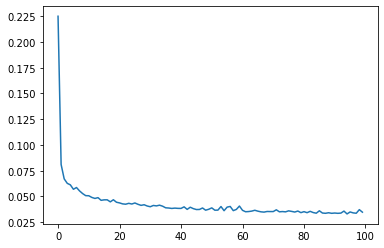

In [ ]:
plt.plot(hist.history['loss'])

In [ ]:
pre=mod.predict([X[no_dum],X[cat]])
pre.shape

(1097231, 256)

In [ ]:
pd.DataFrame(pre).to_csv('/content/gdrive/My Drive/fraud/with_id.csv')